In [1]:
%load_ext autoreload
%autoreload 1
%aimport helpers, loaders, plotters

In [2]:
from pprint import pprint
from math import ceil, floor
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from helpers import balanced_accuracy_scorer, load_best_result, save_search_result, scikit_cv_result_to_df
from loaders import load_adult, load_mnist
from plotters import plot_means_w_stds, gen_and_plot_learning_curve, plot_learning_curve, gen_and_plot_validation_curve, plot_validation_curve

### Load Data

In [3]:
dataset = 'adult'
learner_type = 'SVM'
loader_func = load_adult

In [4]:
df = loader_func(preprocess=True)

Dataset shape (30162, 105)
Value composition:
0    0.751078
1    0.248922
Name: target, dtype: float64


### Split data into training and testing

In [5]:
X = df[[c for c in df.columns if c != 'target']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

### Scale Data

In [6]:
# Use min max scaling because input dataset is sparse, i.e. mostly zeros
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Support Vector Machine Model Complexity
Sources:
1. https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0
2. https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python

#### Hyperparameters for SVMs

**Kernel:** The kernel function used to perform the "kernel trick"

**C:** Penalty parameter C of the error term. The regularization parameter. Can determine the resistance to outliers. Intuitively, this determines how hard the algorithm tries to find the largest margin. For larger values of C, the algorithm will try to fit all data points. For lower values of C, it will prefer the largest margin.

**gamma:** Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. If gamma is ‘auto’ then 1/n_features will be used instead.

In [7]:
from sklearn.svm import SVC

base_clf = SVC(max_iter=100000)

base_clf.get_params()

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': 100000,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [8]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['poly', 'rbf']
#     'kernel': ['linear', 'poly', 'rbf']
}

In [9]:
grid_search = GridSearchCV(
    estimator=base_clf,
    param_grid=param_grid,
    scoring=balanced_accuracy_scorer,
    return_train_score=True,
    cv=4,
    verbose=10,
    n_jobs=1,
)

In [10]:
# from sklearn.externals.joblib import parallel_backend

# with parallel_backend('threading'):
grid_search.fit(X_train_scaled, y_train)

Fitting 4 folds for each of 40 candidates, totalling 160 fits
[CV] C=0.001, gamma=0.001, kernel=poly ...............................
[CV]  C=0.001, gamma=0.001, kernel=poly, score=0.4999999999999999, total=  25.9s
[CV] C=0.001, gamma=0.001, kernel=poly ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.8s remaining:    0.0s


[CV] ..... C=0.001, gamma=0.001, kernel=poly, score=0.5, total=  25.9s
[CV] C=0.001, gamma=0.001, kernel=poly ...............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


[CV] ..... C=0.001, gamma=0.001, kernel=poly, score=0.5, total=  27.0s
[CV] C=0.001, gamma=0.001, kernel=poly ...............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.1min remaining:    0.0s


[CV] ..... C=0.001, gamma=0.001, kernel=poly, score=0.5, total=  26.4s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.8min remaining:    0.0s


[CV]  C=0.001, gamma=0.001, kernel=rbf, score=0.4999999999999999, total=  34.2s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.7min remaining:    0.0s


[CV] ...... C=0.001, gamma=0.001, kernel=rbf, score=0.5, total=  33.0s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  4.6min remaining:    0.0s


[CV] ...... C=0.001, gamma=0.001, kernel=rbf, score=0.5, total=  37.5s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  5.6min remaining:    0.0s


[CV] ...... C=0.001, gamma=0.001, kernel=rbf, score=0.5, total=  32.8s
[CV] C=0.001, gamma=0.01, kernel=poly ................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  6.5min remaining:    0.0s


[CV]  C=0.001, gamma=0.01, kernel=poly, score=0.4999999999999999, total=  30.4s
[CV] C=0.001, gamma=0.01, kernel=poly ................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  7.3min remaining:    0.0s


[CV] ...... C=0.001, gamma=0.01, kernel=poly, score=0.5, total=  27.8s
[CV] C=0.001, gamma=0.01, kernel=poly ................................
[CV] ...... C=0.001, gamma=0.01, kernel=poly, score=0.5, total=  26.3s
[CV] C=0.001, gamma=0.01, kernel=poly ................................
[CV] ...... C=0.001, gamma=0.01, kernel=poly, score=0.5, total=  26.7s
[CV] C=0.001, gamma=0.01, kernel=rbf .................................
[CV]  C=0.001, gamma=0.01, kernel=rbf, score=0.4999999999999999, total=  32.8s
[CV] C=0.001, gamma=0.01, kernel=rbf .................................
[CV] ....... C=0.001, gamma=0.01, kernel=rbf, score=0.5, total=  33.2s
[CV] C=0.001, gamma=0.01, kernel=rbf .................................
[CV] ....... C=0.001, gamma=0.01, kernel=rbf, score=0.5, total=  32.9s
[CV] C=0.001, gamma=0.01, kernel=rbf .................................
[CV] ....... C=0.001, gamma=0.01, kernel=rbf, score=0.5, total=  57.6s
[CV] C=0.001, gamma=0.1, kernel=poly ................................

[CV] ....... C=0.1, gamma=0.001, kernel=poly, score=0.5, total=  24.3s
[CV] C=0.1, gamma=0.001, kernel=poly .................................
[CV] ....... C=0.1, gamma=0.001, kernel=poly, score=0.5, total=  24.8s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV]  C=0.1, gamma=0.001, kernel=rbf, score=0.4999999999999999, total=  32.8s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ........ C=0.1, gamma=0.001, kernel=rbf, score=0.5, total=  32.8s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ........ C=0.1, gamma=0.001, kernel=rbf, score=0.5, total=  32.4s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ........ C=0.1, gamma=0.001, kernel=rbf, score=0.5, total=  33.1s
[CV] C=0.1, gamma=0.01, kernel=poly ..................................
[CV]  C=0.1, gamma=0.01, kernel=poly, score=0.4999999999999999, total=  25.5s
[CV] C=0.1, gamma=0.01, kernel=poly ...........................

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=1, kernel=poly, score=0.7566009470231344, total=  27.2s
[CV] C=0.1, gamma=1, kernel=poly .....................................


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=1, kernel=poly, score=0.752803580781063, total=  27.2s
[CV] C=0.1, gamma=1, kernel=poly .....................................


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=1, kernel=poly, score=0.7652302994837863, total=  27.7s
[CV] C=0.1, gamma=1, kernel=poly .....................................


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=1, kernel=poly, score=0.7553326206789569, total=  27.8s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.6687061061303144, total= 1.0min
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.6519553070480597, total=  60.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.6697240537746876, total= 1.3min
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.666816608225936, total= 1.0min
[CV] C=1, gamma=0.001, kernel=poly ...................................
[CV]  C=1, gamma=0.001, kernel=poly, score=0.4999999999999999, total=  24.9s
[CV] C=1, gamma=0.001, kernel=poly ...................................
[CV] ......... C=1, gamma=0.001, kernel=poly, score=0.5, total=  24.9s
[CV] C=1, gamma=0.001, kernel=poly .....................

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1, gamma=1, kernel=poly, score=0.7476387761251898, total=  31.8s
[CV] C=1, gamma=1, kernel=poly .......................................


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1, gamma=1, kernel=poly, score=0.7497932303977809, total=  32.6s
[CV] C=1, gamma=1, kernel=poly .......................................


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1, gamma=1, kernel=poly, score=0.7569243818414437, total=  31.3s
[CV] C=1, gamma=1, kernel=poly .......................................


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1, gamma=1, kernel=poly, score=0.7541071700095379, total=  31.2s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV]  C=1, gamma=1, kernel=rbf, score=0.7192660858616393, total= 1.3min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV]  C=1, gamma=1, kernel=rbf, score=0.721432773193137, total= 1.7min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV]  C=1, gamma=1, kernel=rbf, score=0.7158490340000645, total= 1.3min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV]  C=1, gamma=1, kernel=rbf, score=0.718262497945743, total= 1.7min
[CV] C=10, gamma=0.001, kernel=poly ..................................
[CV]  C=10, gamma=0.001, kernel=poly, score=0.4999999999999999, total=  24.0s
[CV] C=10, gamma=0.001, kernel=poly ..................................
[CV] ........ C=10, gamma=0.001, kernel=poly, score=0.5, total=  24.0s
[CV] C=10, gamma=0.001, kernel=poly ..............................

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10, gamma=1, kernel=poly, score=0.7394420548137144, total=  41.7s
[CV] C=10, gamma=1, kernel=poly ......................................


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10, gamma=1, kernel=poly, score=0.7508593321629828, total=  42.8s
[CV] C=10, gamma=1, kernel=poly ......................................


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10, gamma=1, kernel=poly, score=0.7435223710502591, total=  41.0s
[CV] C=10, gamma=1, kernel=poly ......................................


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10, gamma=1, kernel=poly, score=0.7427550004838063, total=  40.4s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV]  C=10, gamma=1, kernel=rbf, score=0.7326018568102556, total= 1.9min
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV]  C=10, gamma=1, kernel=rbf, score=0.7307251181485731, total= 1.9min
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV]  C=10, gamma=1, kernel=rbf, score=0.730207906163078, total= 1.9min
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV]  C=10, gamma=1, kernel=rbf, score=0.7239892671793478, total= 2.0min


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 132.7min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=100000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['poly', 'rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(balanced_accuracy), verbose=10)

In [11]:
save_search_result(grid_search, dataset, learner_type)

### Analysis

In [12]:
res = grid_search.cv_results_

In [13]:
res_df = scikit_cv_result_to_df(res)

In [14]:
res_df.sort_values(by='rank_test_score').head(10)

mean_fit_time  std_fit_time  mean_score_time  \
C      gamma kernel                                                 
10.000 0.10  rbf         24.739288      0.247165         4.550367   
             poly        20.748285      0.457635         3.466901   
0.010  1.00  poly        21.040993      0.135899         3.474905   
0.100  1.00  poly        24.220151      0.296954         3.242175   
1.000  1.00  poly        28.550574      0.544201         3.182571   
10.000 1.00  poly        38.151691      0.837217         3.327443   
1.000  0.10  poly        18.182402      0.316992         3.555689   
0.001  1.00  poly        18.428320      0.197682         3.597868   
1.000  0.10  rbf         22.491006      0.196845         4.675996   
10.000 0.01  rbf         22.481263      0.422982         4.649929   

                     std_score_time  mean_test_score  std_test_score  \
C      gamma kernel                                                    
10.000 0.10  rbf           0.022704         0.762876        0.005207   
             poly          0.004447         0.757584        0.003784   
0.010  1.00  poly          0.025928         0.757553        0.003782   
0.100  1.00  poly          0.021401         0.757492        0.004672   
1.000  1.00  poly          0.037332         0.752116        0.003624   
10.000 1.00  poly          0.073669         0.744144        0.004169   
1.000  0.10  poly          0.043398         0.742376        0.004076   
0.001  1.00  poly          0.025018         0.742376        0.004076   
1.000  0.10  rbf           0.056169         0.741646        0.003325   
10.000 0.01  rbf           0.008820         0.735404        0.003968   

                     rank_test_score  mean_train_score  std_train_score  
C      gamma kernel                                                      
10.000 0.10  rbf                   1          0.802845         0.002713  
             poly                  2          0.803308         0.001863  
0.010  1.00  poly                  3          0.803350         0.001853  
0.100  1.00  poly                  4          0.836284         0.003037  
1.000  1.00  poly                  5          0.858875         0.003116  
10.000 1.00  poly                  6          0.880744         0.003458  
1.000  0.10  poly                  7          0.752761         0.005182  
0.001  1.00  poly                  7          0.752761         0.005182  
1.000  0.10  rbf                   9          0.750690         0.004075  
10.000 0.01  rbf                  10          0.739342         0.003737

In [15]:
rbf = res_df.xs('rbf', level='kernel')
rbf = rbf.reset_index()
# lin = res_df.xs('linear', level='kernel')
# lin = lin.reset_index()
poly = res_df.xs('poly', level='kernel')
poly = poly.reset_index()

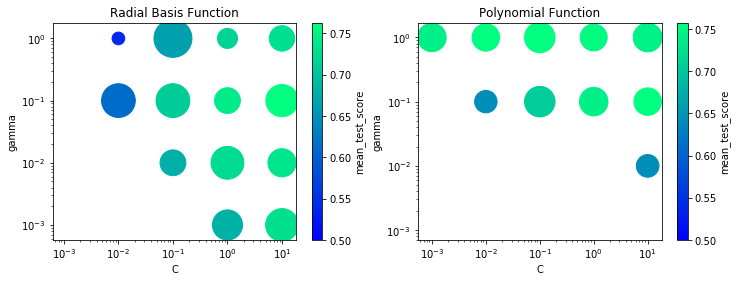

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

ax1.set_title('Radial Basis Function')
rbf.plot(kind='scatter', x='C', y='gamma', c='mean_test_score', s=rbf['std_test_score']*200000, cmap='winter', logx=True, logy=True, ax=ax1)

ax2.set_title('Polynomial Function')
poly.plot(kind='scatter', x='C', y='gamma', c='mean_test_score', s=poly['std_test_score']*200000, cmap='winter', logx=True, logy=True, ax=ax2)


# Gamma has no effect for linear kernel
# ax3.set_title('Linear Function')
# lin.plot(kind='scatter', x='C', y='gamma', c='mean_test_score', s=lin['std_test_score']*100000, cmap='winter', logx=True, logy=True, ax=ax3)

In [17]:
# Helper function needed for std==0.0
def std_to_size(std):
    if std > 0:
        return std * 200000
    else:
        return 10

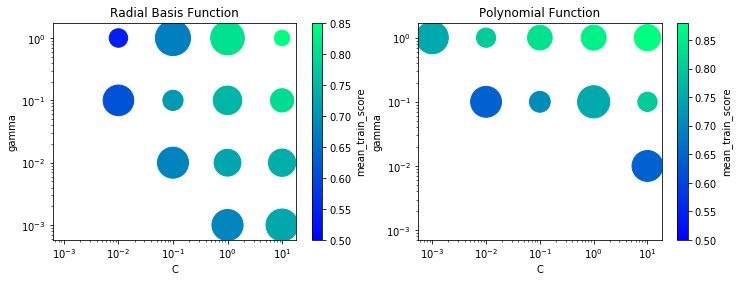

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

ax1.set_title('Radial Basis Function')
rbf.plot(kind='scatter', x='C', y='gamma', c='mean_train_score', s=rbf['std_train_score'].apply(std_to_size), cmap='winter', logx=True, logy=True, ax=ax1)

ax2.set_title('Polynomial Function')
poly.plot(kind='scatter', x='C', y='gamma', c='mean_train_score', s=poly['std_train_score'].apply(std_to_size), cmap='winter', logx=True, logy=True, ax=ax2)

# ax3.set_title('Linear Function')
# lin.plot(kind='scatter', x='C', y='gamma', c='mean_train_score', s=lin['std_train_score'].apply(std_to_size), cmap='winter', logx=True, logy=True, ax=ax3)

### Timing statistics

In [19]:
# Helper function needed for std==0.0
def std_to_size(std):
    if std > 0:
        return std * 50
    else:
        return 10

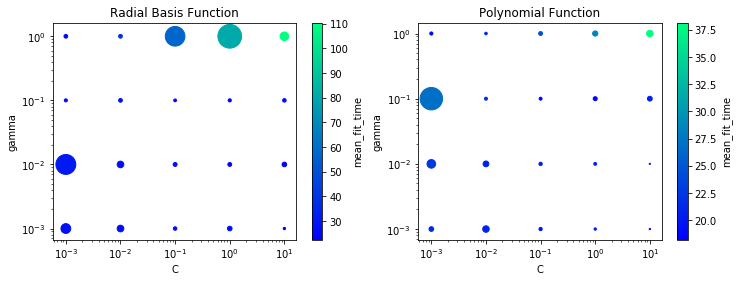

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

ax1.set_title('Radial Basis Function')
rbf.plot(kind='scatter', x='C', y='gamma', c='mean_fit_time', s=rbf['std_fit_time'].apply(std_to_size), cmap='winter', logx=True, logy=True, ax=ax1)

ax2.set_title('Polynomial Function')
poly.plot(kind='scatter', x='C', y='gamma', c='mean_fit_time', s=poly['std_fit_time'].apply(std_to_size), cmap='winter', logx=True, logy=True, ax=ax2)

### What is the best estimator?

In [21]:
grid_search.best_estimator_.get_params()

{'C': 10,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.1,
 'kernel': 'rbf',
 'max_iter': 100000,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [22]:
grid_search.best_score_

0.76287573694013378

## SVM Learning Curve Analysis

In [26]:
# Find best estimator
best_params = res['params'][np.argmin(res['rank_test_score'])]
best_params['verbose'] =10
clf = SVC(**best_params, max_iter=1000000)
clf.get_params()

{'C': 10,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.1,
 'kernel': 'rbf',
 'max_iter': 1000000,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': 10}

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

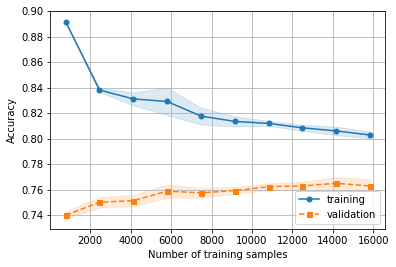

In [27]:
train_sizes, _, _, train_mean, train_std, test_mean, test_std = gen_and_plot_learning_curve(clf, X_train_scaled, y_train, ylim=None, cv=4, train_sizes=np.linspace(.05, 1.0, 10), n_jobs=1, scoring=balanced_accuracy_scorer)